<a href="https://colab.research.google.com/github/7201krap/PYTORCH_introduction_to_pytorch/blob/main/MNIST_adagrad_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [5]:
mnist_trainset = datasets.MNIST(root='./data', train=True, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

mnist_testset  = datasets.MNIST(root='./data', 
                                train=False, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, 
                                               batch_size=50, 
                                               shuffle=True)

test_dataloader  = torch.utils.data.DataLoader(mnist_testset, 
                                               batch_size=50, 
                                               shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Testing dataset size: ",  len(mnist_testset))

Training dataset size:  60000
Testing dataset size:  10000


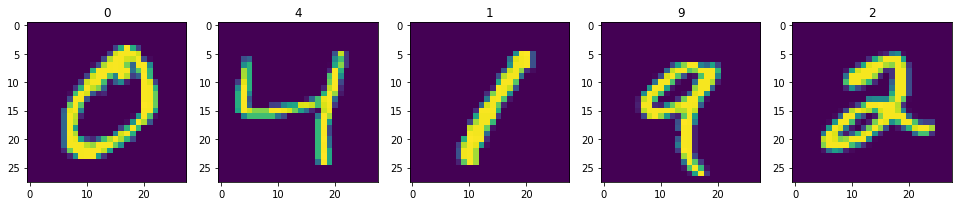

In [6]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()

In [7]:
# Define the model 
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = torch.nn.Linear(784, 256)
        self.linear_2 = torch.nn.Linear(256, 10)
        self.sigmoid  = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.sigmoid(x)
        pred = self.linear_2(x)

        return pred

model = Model()

In [8]:
def get_activation():    
    def hook(module, input, output):
        model.layer_activations = output
    return hook
    
model.linear_1.register_forward_hook(get_activation())

In [9]:
# adagrad 
adagrad_optimizer  = torch.optim.Adagrad(model.parameters(), lr=0.1)

In [10]:
# trainer 
no_epochs = 20

def my_trainer(optimizer, model):

    criterion = torch.nn.CrossEntropyLoss()

    train_loss = list()
    test_loss  = list()
    test_acc   = list()

    # define activation list 
    hidden_layer_activation_list = list()

    best_test_loss = 1

    for epoch in range(no_epochs):
        total_train_loss = 0
        total_test_loss = 0

        # training
        # set up training mode 
        model.train()
    
        for itr, (image, label) in enumerate(train_dataloader):

            optimizer.zero_grad()

            pred = model(image)

            loss = criterion(pred, label)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Print/Append activation of the hidden layer 
            # print(model.layer_activations.shape)
            hidden_layer_activation_list.append(model.layer_activations)

        total_train_loss = total_train_loss / (itr + 1)
        train_loss.append(total_train_loss)

        # testing 
        # change to evaluation mode 
        model.eval()
        total = 0
        for itr, (image, label) in enumerate(test_dataloader):

            pred = model(image)

            loss = criterion(pred, label)
            total_test_loss += loss.item()

            # we now need softmax because we are testing.
            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        # caculate accuracy 
        accuracy = total / len(mnist_testset)

        # append accuracy here
        test_acc.append(accuracy)

        # append test loss here 
        total_test_loss = total_test_loss / (itr + 1)
        test_loss.append(total_test_loss)

        print('\nEpoch: {}/{}, Train Loss: {:.8f}, Test Loss: {:.8f}, Test Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_test_loss, accuracy))

        if total_test_loss < best_test_loss:
            best_test_loss = total_test_loss
            print("Saving the model state dictionary for Epoch: {} with Test loss: {:.8f}".format(epoch + 1, total_test_loss))
            torch.save(model.state_dict(), "model.dth")

    return no_epochs, test_acc, test_loss, hidden_layer_activation_list

In [11]:
print("\n===== Entering Adagrad optimizer =====\n")
adagrad_no_epochs,  adagrad_test_acc, adagrad_test_loss, adagrad_hidden_layer_activation_list   = my_trainer(optimizer=adagrad_optimizer, model=model)


===== Entering Adagrad optimizer =====


Epoch: 1/20, Train Loss: 0.23588285, Test Loss: 0.12202381, Test Accuracy: 0.96300000
Saving the model state dictionary for Epoch: 1 with Test loss: 0.12202381

Epoch: 2/20, Train Loss: 0.09488135, Test Loss: 0.09074931, Test Accuracy: 0.97170000
Saving the model state dictionary for Epoch: 2 with Test loss: 0.09074931

Epoch: 3/20, Train Loss: 0.06617821, Test Loss: 0.08113048, Test Accuracy: 0.97310000
Saving the model state dictionary for Epoch: 3 with Test loss: 0.08113048

Epoch: 4/20, Train Loss: 0.04967527, Test Loss: 0.07593738, Test Accuracy: 0.97610000
Saving the model state dictionary for Epoch: 4 with Test loss: 0.07593738

Epoch: 5/20, Train Loss: 0.03886569, Test Loss: 0.07064993, Test Accuracy: 0.97710000
Saving the model state dictionary for Epoch: 5 with Test loss: 0.07064993

Epoch: 6/20, Train Loss: 0.03122390, Test Loss: 0.06679255, Test Accuracy: 0.97810000
Saving the model state dictionary for Epoch: 6 with Test loss: 0.06

In [12]:
print(adagrad_hidden_layer_activation_list[0].shape)
print(len(adagrad_hidden_layer_activation_list))

torch.Size([50, 256])
24000


In [17]:
layer_activations_list = adagrad_hidden_layer_activation_list

In [18]:
print(torch.abs(torch.stack(layer_activations_list)).shape)

layer_activations_list = torch.abs(torch.stack(layer_activations_list))

num_neurons            = layer_activations_list.shape[1]
population_sparseness  = (np.sqrt(num_neurons) - (torch.sum(layer_activations_list, dim=1) / torch.sqrt(torch.sum(layer_activations_list ** 2, dim=1)))) / (np.sqrt(num_neurons) - 1)

print(torch.mean(population_sparseness))

torch.Size([24000, 50, 256])
tensor(0.1520, grad_fn=<MeanBackward0>)


In [15]:
# fig=plt.figure(figsize=(20, 10))
# plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
# plt.plot(np.arange(1, no_epochs+1), test_loss,  label="Test loss")
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title("Loss Plots")
# plt.legend(loc='best')
# plt.show()

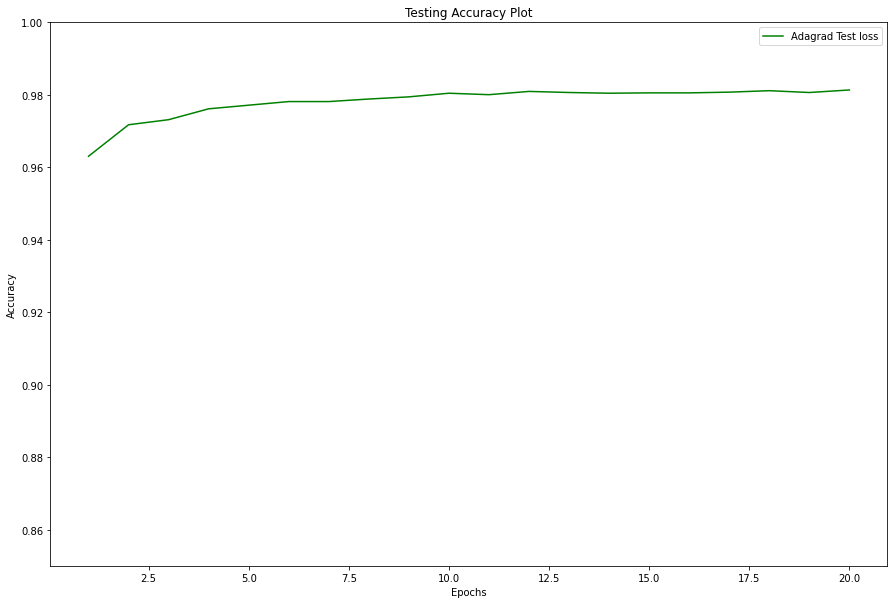

In [16]:
fig = plt.figure(figsize=(15, 10))
plt.plot(np.arange(1, no_epochs+1), adagrad_test_acc,   label="Adagrad Test loss", color='g')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1)
plt.title("Testing Accuracy Plot")
plt.legend(loc='best')
plt.show()